In [1]:
import numpy as np
import pandas as pd
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors
import mordred

In [2]:
df = pd.read_csv('./data/origin.csv',index_col=0)
df

,entry,R1-,organocatalyst,organocatalyst(mol%),temp(℃),time(h),yield,R2_C,R2_H,under_O2,under_air,solvent_CH3CN,solvent_DMF,solvent_MeOH,solvent_toluene
0,1,[*]C1=CC=CC=C1,ClC1=CC=C(C(O)=O)C(O)=C1,5.0,90,24.0,81.0,0,1,1,0,0,0,0,1
1,2,[*]C1=CC=CC=C1,ClC1=CC=C(C(O)=O)C(O)=C1,5.0,90,12.0,14.0,0,1,1,0,0,0,0,1
2,3,[*]C1=CC=CC=C1,OC1=CC(C)=CC=C1C(O)=O,5.0,90,24.0,74.0,0,1,1,0,0,0,0,1
3,4,[*]C1=CC=CC=C1,OC1=CC(C)=CC=C1C(O)=O,5.0,90,12.0,15.0,0,1,1,0,0,0,0,1
4,5,[*]C1=CC=CC=C1,OC1=CC(OC)=CC=C1C(O)=O,5.0,90,24.0,90.0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2i,[*]C1=CC(Br)=CC=C1,O=C1C(C=C(OC)C(C(C)(C)C)=C1)=O,10.0,23,72.0,95.0,1,0,1,0,1,0,0,0
117,2j,[*]C1=CC=CC(OC)=C1,O=C1C(C=C(OC)C(C(C)(C)C)=C1)=O,10.0,23,48.0,89.0,1,0,1,0,1,0,0,0
118,2k,[*]C1=CC(C)=C(C)C=C1,O=C1C(C=C(OC)C(C(C)(C)C)=C1)=O,10.0,23,72.0,99.0,1,0,1,0,1,0,0,0
119,2m,[*]C1=CSC=C1,O=C1C(C=C(OC)C(C(C)(C)C)=C1)=O,10.0,60,48.0,83.0,1,0,1,0,1,0,0,0


In [3]:
mols_r1 = list(Chem.MolFromSmiles(smile) for smile in df['R1-'].values)
mols_organocatalyst = list(Chem.MolFromSmiles(smile) for smile in df['organocatalyst'].values)

# Rdkit記述子に変換

In [4]:
def toFingerRdkit(mols,prefix):
    descriptor_names = [(descriptor_name[0] + '_' + prefix) for descriptor_name in Descriptors.descList]
    descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    rdkit_descriptors_results = [descriptor_calculator.CalcDescriptors(mol) for mol in mols]
    df_rdkit = pd.DataFrame(rdkit_descriptors_results, columns=descriptor_names)
    df_rdkit = df_rdkit[df_rdkit.columns[~df_rdkit.isnull().any()]]
    return df_rdkit

In [5]:
df_rdkit_r1 = toFingerRdkit(mols_r1, 'r1')
df_rdkit_organocatalyst = toFingerRdkit(mols_organocatalyst, 'organocatalyst')

In [6]:
print(df_rdkit_r1.shape)
print(df_rdkit_organocatalyst.shape)

(121, 208)
(121, 208)


# Mordred記述子の変換を行う

In [7]:
def toFingerMordred(mols):
    mordered_calculator = Calculator(descriptors,ignore_3D=True)
    df_mordred = mordered_calculator.pandas(pd.Series(mols))
    
    for column in df_mordred.columns:
        if df_mordred[column].dtypes == object:
            df_mordred[column] = df_mordred[column].values.astype(np.float32)
    
    df_mordered = df_mordred[df_mordred.columns[~df_mordred.isnull().any()]]
    return df_mordered

In [8]:
df_mordred_r1 = toFingerMordred(mols_r1)
df_mordred_organocatalyst = toFingerMordred(mols_organocatalyst)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:26<00:00,  4.49it/s]


In [9]:
df_rdkit_r1.to_csv('./data/method4/rdkit_r1.csv')
df_rdkit_organocatalyst.to_csv('./data/method4/rdkit_organocatalyst.csv')
df_mordred_r1.to_csv('./data/method4/mordred_r1.csv')
df_mordred_organocatalyst.to_csv('./data/method4/mordred_organocatalyst.csv')

In [10]:
df_dropped = df.drop(columns=['entry', 'R1-', 'organocatalyst'])
r1_names = ['rdkit_r1','mordred_r1']
organo_names = ['rdkit_organo', 'mordred_organo']

for r1_name, df_r1 in zip(r1_names, [df_rdkit_r1,df_mordred_r1]):
    for organo_name, df_organocatalyst in zip(organo_names, [df_rdkit_organocatalyst, df_mordred_organocatalyst]):
        _df = pd.concat([df_dropped,df_r1, df_organocatalyst], axis=1)
        _df.to_csv(f'./data/method4/dataset_{r1_name}_{organo_name}.csv')


# 特徴量選択
1. 分散0の説明変数を除去
2. 9割以上が同じ値になる記述子を削除
3. 0.95以上の説明変数の組みがある場合どちらかを除去
4. オートスケーリング

In [11]:
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def selectFeature(df):
    select = VarianceThreshold()
    select_values = select.fit_transform(df.values)
    df_selected = df[df.columns[select.get_support()]]
    
    st_threshold = 0.9
    selected = []
    for column in df_selected:
        value_counts = df_selected[column].value_counts(sort=True)
        # 全体に対して何割同じ値があるか
        score = value_counts.values[0] / len(df_selected[column].values)
        if score < st_threshold:
            selected.append(column)
    df_selected = df_selected[selected]
    
    # 相関が0.95以上のカラムを除去
    df_selected = deleteHighCorrColumn(df_selected)
    
    return df_selected
        

def deleteHighCorrColumn(df):
    threshold = 0.95
    df_corr = df.corr()
    df_corr = abs(df_corr)
    columns = df_corr.columns

    # 対角線の値を0にする
    for i in range(0, len(columns)):
        df_corr.iloc[i, i] = 0

    while True:
        columns = df_corr.columns
        max_corr = 0.0
        query_column = None
        target_column = None

        df_max_column_value = df_corr.max()
        max_corr = df_max_column_value.max()
        query_column = df_max_column_value.idxmax()
        target_column = df_corr[query_column].idxmax()

        if max_corr < threshold:
            # しきい値を超えるものがなかったため終了
            break
        else:
            # しきい値を超えるものがあった場合
            delete_column = None
            saved_column = None

            # その他との相関の絶対値が大きい方を除去
            if sum(df_corr[query_column]) <= sum(df_corr[target_column]):
                delete_column = target_column
                saved_column = query_column
            else:
                delete_column = query_column
                saved_column = target_column

            # 除去すべき特徴を相関行列から消す（行、列）
            df_corr.drop([delete_column], axis=0, inplace=True)
            df_corr.drop([delete_column], axis=1, inplace=True)

    return df[df_corr.columns]


In [12]:
df1 = pd.read_csv('./data/method4/dataset_mordred_r1_mordred_organo.csv',index_col=0)
df2 = pd.read_csv('./data/method4/dataset_rdkit_r1_rdkit_organo.csv',index_col=0)
df3 = pd.read_csv('./data/method4/dataset_rdkit_r1_mordred_organo.csv',index_col=0)
df4 = pd.read_csv('./data/method4/dataset_mordred_r1_rdkit_organo.csv',index_col=0)

In [13]:
selectFeature(df1).to_csv('./data/method4/mordred_r1_mordred_organo.csv')
selectFeature(df2).to_csv('./data/method4/rdkit_r1_rdkit_organo.csv')
selectFeature(df3).to_csv('./data/method4/rdkit_r1_mordred_organo.csv')
selectFeature(df4).to_csv('./data/method4/mordred_r1_rdkit_organo.csv')

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


def scale(df):
    # scaling
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['yield']), df['yield'], test_size=0.2, random_state=0)
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train.values)
    X_test_scaled = ss.transform(X_test.values)
    return [X_train_scaled,X_test_scaled,y_train,y_test]

import optuna
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
def objective(trial, x, t, cv):
    # 1. ハイパーパラメータごとに探索範囲を指定
    n_estimaters = trial.suggest_int('n_estimators', 1, 100)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    num_leaves = trial.suggest_int('num_leaves', 2, 10)
    min_child_weight = trial.suggest_loguniform("min_child_weight", 0.1, 10)
    subsample = trial.suggest_uniform("subsample",0.55, 0.95)    
    colsample_bytree = trial.suggest_uniform("subsample",0.55, 0.95)    

    # 2. 学習に使用するアルゴリズムを指定
    estimator = LGBMRegressor(
        n_estimators=n_estimaters,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree= colsample_bytree,
        random_state=43
    )

    # 3. 学習の実行、検証結果の表示
    print('Current_params : ', trial.params)
    r2 = cross_val_score(estimator, x, t, cv=cv, scoring="r2").mean()
    return r2

/Users/watanabeyuitou/opt/anaconda3/envs/chem/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# study オブジェクトの作成（最大化）
study = optuna.create_study(direction='maximize')
# 10分割交差検証によるチューニング
cv = 10
[X_train_scaled,X_test_scaled,y_train,y_test] = scale(df4)
study.optimize(lambda trial: objective(trial, X_train_scaled, y_train, cv), n_trials=50)

[I 2022-12-10 23:00:25,058] A new study created in memory with name: no-name-d252d207-30d5-4a8f-af61-a343279372f5


Current_params :  {'n_estimators': 12, 'max_depth': 2, 'num_leaves': 3, 'min_child_weight': 1.2164788335269772, 'subsample': 0.6241369188325241}


[I 2022-12-10 23:00:25,443] Trial 0 finished with value: 0.11220813574276396 and parameters: {'n_estimators': 12, 'max_depth': 2, 'num_leaves': 3, 'min_child_weight': 1.2164788335269772, 'subsample': 0.6241369188325241}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 51, 'max_depth': 8, 'num_leaves': 6, 'min_child_weight': 4.180386663943176, 'subsample': 0.6536789564228686}


[I 2022-12-10 23:00:25,861] Trial 1 finished with value: 0.07198990708555988 and parameters: {'n_estimators': 51, 'max_depth': 8, 'num_leaves': 6, 'min_child_weight': 4.180386663943176, 'subsample': 0.6536789564228686}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:26,064] Trial 2 finished with value: 0.089126845831709 and parameters: {'n_estimators': 47, 'max_depth': 1, 'num_leaves': 9, 'min_child_weight': 0.5785273306561051, 'subsample': 0.8095672150216993}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 47, 'max_depth': 1, 'num_leaves': 9, 'min_child_weight': 0.5785273306561051, 'subsample': 0.8095672150216993}
Current_params :  {'n_estimators': 83, 'max_depth': 5, 'num_leaves': 10, 'min_child_weight': 2.2299211973062323, 'subsample': 0.863162077379205}


[I 2022-12-10 23:00:26,437] Trial 3 finished with value: 0.08923697277249608 and parameters: {'n_estimators': 83, 'max_depth': 5, 'num_leaves': 10, 'min_child_weight': 2.2299211973062323, 'subsample': 0.863162077379205}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 68, 'max_depth': 3, 'num_leaves': 10, 'min_child_weight': 7.507347574978578, 'subsample': 0.5731758691383185}


[I 2022-12-10 23:00:26,829] Trial 4 finished with value: 0.07962054825366133 and parameters: {'n_estimators': 68, 'max_depth': 3, 'num_leaves': 10, 'min_child_weight': 7.507347574978578, 'subsample': 0.5731758691383185}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 98, 'max_depth': 3, 'num_leaves': 5, 'min_child_weight': 2.3217452727435166, 'subsample': 0.6576845818480185}


[I 2022-12-10 23:00:27,295] Trial 5 finished with value: 0.0877782213950807 and parameters: {'n_estimators': 98, 'max_depth': 3, 'num_leaves': 5, 'min_child_weight': 2.3217452727435166, 'subsample': 0.6576845818480185}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 85, 'max_depth': 1, 'num_leaves': 5, 'min_child_weight': 0.7775904624571656, 'subsample': 0.6451296161739644}


[I 2022-12-10 23:00:27,863] Trial 6 finished with value: 0.09666116552876006 and parameters: {'n_estimators': 85, 'max_depth': 1, 'num_leaves': 5, 'min_child_weight': 0.7775904624571656, 'subsample': 0.6451296161739644}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 84, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.9539235779066783, 'subsample': 0.9088257006830371}


[I 2022-12-10 23:00:28,404] Trial 7 finished with value: 0.08618542483627427 and parameters: {'n_estimators': 84, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.9539235779066783, 'subsample': 0.9088257006830371}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:28,604] Trial 8 finished with value: 0.06709599630904876 and parameters: {'n_estimators': 41, 'max_depth': 2, 'num_leaves': 10, 'min_child_weight': 3.652377496316037, 'subsample': 0.6754275792883173}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 41, 'max_depth': 2, 'num_leaves': 10, 'min_child_weight': 3.652377496316037, 'subsample': 0.6754275792883173}
Current_params :  {'n_estimators': 62, 'max_depth': 8, 'num_leaves': 6, 'min_child_weight': 1.8404724935271828, 'subsample': 0.7906038444287573}


[I 2022-12-10 23:00:28,871] Trial 9 finished with value: 0.08057452544607253 and parameters: {'n_estimators': 62, 'max_depth': 8, 'num_leaves': 6, 'min_child_weight': 1.8404724935271828, 'subsample': 0.7906038444287573}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:29,027] Trial 10 finished with value: -0.07136271253309699 and parameters: {'n_estimators': 2, 'max_depth': 10, 'num_leaves': 2, 'min_child_weight': 0.15636125811103635, 'subsample': 0.5523107924587567}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 2, 'max_depth': 10, 'num_leaves': 2, 'min_child_weight': 0.15636125811103635, 'subsample': 0.5523107924587567}
Current_params :  {'n_estimators': 17, 'max_depth': 1, 'num_leaves': 3, 'min_child_weight': 0.38871579059784134, 'subsample': 0.7143940792324102}


[I 2022-12-10 23:00:29,219] Trial 11 finished with value: 0.08056164498810287 and parameters: {'n_estimators': 17, 'max_depth': 1, 'num_leaves': 3, 'min_child_weight': 0.38871579059784134, 'subsample': 0.7143940792324102}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:29,415] Trial 12 finished with value: 0.08469034647932237 and parameters: {'n_estimators': 25, 'max_depth': 5, 'num_leaves': 4, 'min_child_weight': 0.406596204529976, 'subsample': 0.5989994773364407}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 25, 'max_depth': 5, 'num_leaves': 4, 'min_child_weight': 0.406596204529976, 'subsample': 0.5989994773364407}
Current_params :  {'n_estimators': 29, 'max_depth': 1, 'num_leaves': 4, 'min_child_weight': 0.8932356245535545, 'subsample': 0.6274223438674017}


[I 2022-12-10 23:00:29,641] Trial 13 finished with value: 0.07304171829607717 and parameters: {'n_estimators': 29, 'max_depth': 1, 'num_leaves': 4, 'min_child_weight': 0.8932356245535545, 'subsample': 0.6274223438674017}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:29,792] Trial 14 finished with value: 0.01885362747264956 and parameters: {'n_estimators': 5, 'max_depth': 4, 'num_leaves': 2, 'min_child_weight': 0.21005374877117963, 'subsample': 0.7237717055055157}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 5, 'max_depth': 4, 'num_leaves': 2, 'min_child_weight': 0.21005374877117963, 'subsample': 0.7237717055055157}
Current_params :  {'n_estimators': 72, 'max_depth': 6, 'num_leaves': 7, 'min_child_weight': 1.3094303404882959, 'subsample': 0.766175050751789}


[I 2022-12-10 23:00:30,135] Trial 15 finished with value: 0.08684913928345792 and parameters: {'n_estimators': 72, 'max_depth': 6, 'num_leaves': 7, 'min_child_weight': 1.3094303404882959, 'subsample': 0.766175050751789}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 100, 'max_depth': 2, 'num_leaves': 4, 'min_child_weight': 0.5960154280175576, 'subsample': 0.6960391735557611}


[I 2022-12-10 23:00:30,500] Trial 16 finished with value: 0.09264357157624326 and parameters: {'n_estimators': 100, 'max_depth': 2, 'num_leaves': 4, 'min_child_weight': 0.5960154280175576, 'subsample': 0.6960391735557611}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 40, 'max_depth': 7, 'num_leaves': 5, 'min_child_weight': 0.25832173659461527, 'subsample': 0.6057811922645997}


[I 2022-12-10 23:00:30,716] Trial 17 finished with value: 0.0559374091930244 and parameters: {'n_estimators': 40, 'max_depth': 7, 'num_leaves': 5, 'min_child_weight': 0.25832173659461527, 'subsample': 0.6057811922645997}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 58, 'max_depth': 2, 'num_leaves': 3, 'min_child_weight': 0.11654308232818143, 'subsample': 0.6299491579906329}


[I 2022-12-10 23:00:30,969] Trial 18 finished with value: 0.07877502561277766 and parameters: {'n_estimators': 58, 'max_depth': 2, 'num_leaves': 3, 'min_child_weight': 0.11654308232818143, 'subsample': 0.6299491579906329}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 80, 'max_depth': 4, 'num_leaves': 5, 'min_child_weight': 1.23788014002978, 'subsample': 0.7615596592768024}


[I 2022-12-10 23:00:31,281] Trial 19 finished with value: 0.08993851737434436 and parameters: {'n_estimators': 80, 'max_depth': 4, 'num_leaves': 5, 'min_child_weight': 1.23788014002978, 'subsample': 0.7615596592768024}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:31,452] Trial 20 finished with value: 0.10503731903861598 and parameters: {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.6334691483354666, 'subsample': 0.584344409632916}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.6334691483354666, 'subsample': 0.584344409632916}
Current_params :  {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.6458567989357992, 'subsample': 0.5879940016069644}


[I 2022-12-10 23:00:31,648] Trial 21 finished with value: 0.10503731903861598 and parameters: {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.6458567989357992, 'subsample': 0.5879940016069644}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:31,809] Trial 22 finished with value: 0.10112481208229321 and parameters: {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.39067267893481267, 'subsample': 0.5787562218854615}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.39067267893481267, 'subsample': 0.5787562218854615}
Current_params :  {'n_estimators': 13, 'max_depth': 6, 'num_leaves': 7, 'min_child_weight': 1.522134586660042, 'subsample': 0.5502729602721841}


[I 2022-12-10 23:00:31,994] Trial 23 finished with value: 0.11137817080155554 and parameters: {'n_estimators': 13, 'max_depth': 6, 'num_leaves': 7, 'min_child_weight': 1.522134586660042, 'subsample': 0.5502729602721841}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:32,194] Trial 24 finished with value: 0.08311681860152585 and parameters: {'n_estimators': 28, 'max_depth': 6, 'num_leaves': 8, 'min_child_weight': 1.5513950968961354, 'subsample': 0.5506933357424906}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 28, 'max_depth': 6, 'num_leaves': 8, 'min_child_weight': 1.5513950968961354, 'subsample': 0.5506933357424906}


[I 2022-12-10 23:00:32,373] Trial 25 finished with value: 0.0886576036170131 and parameters: {'n_estimators': 8, 'max_depth': 7, 'num_leaves': 8, 'min_child_weight': 3.191606729813476, 'subsample': 0.606466510282906}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 8, 'max_depth': 7, 'num_leaves': 8, 'min_child_weight': 3.191606729813476, 'subsample': 0.606466510282906}
Current_params :  {'n_estimators': 20, 'max_depth': 5, 'num_leaves': 7, 'min_child_weight': 5.994098619458045, 'subsample': 0.6187880664580623}


[I 2022-12-10 23:00:32,666] Trial 26 finished with value: 0.08772121103288957 and parameters: {'n_estimators': 20, 'max_depth': 5, 'num_leaves': 7, 'min_child_weight': 5.994098619458045, 'subsample': 0.6187880664580623}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 34, 'max_depth': 10, 'num_leaves': 6, 'min_child_weight': 1.1994888636697383, 'subsample': 0.554451451673661}


[I 2022-12-10 23:00:33,006] Trial 27 finished with value: 0.06803280110864642 and parameters: {'n_estimators': 34, 'max_depth': 10, 'num_leaves': 6, 'min_child_weight': 1.1994888636697383, 'subsample': 0.554451451673661}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 8, 'max_depth': 7, 'num_leaves': 9, 'min_child_weight': 2.10884374418124, 'subsample': 0.6792033003668385}


[I 2022-12-10 23:00:33,242] Trial 28 finished with value: 0.08068698461063258 and parameters: {'n_estimators': 8, 'max_depth': 7, 'num_leaves': 9, 'min_child_weight': 2.10884374418124, 'subsample': 0.6792033003668385}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 22, 'max_depth': 9, 'num_leaves': 6, 'min_child_weight': 4.713905114367304, 'subsample': 0.6602464653919672}


[I 2022-12-10 23:00:33,529] Trial 29 finished with value: 0.08463205380268427 and parameters: {'n_estimators': 22, 'max_depth': 9, 'num_leaves': 6, 'min_child_weight': 4.713905114367304, 'subsample': 0.6602464653919672}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 34, 'max_depth': 6, 'num_leaves': 9, 'min_child_weight': 2.756359175873123, 'subsample': 0.5825108839288007}


[I 2022-12-10 23:00:33,923] Trial 30 finished with value: 0.06414701784015983 and parameters: {'n_estimators': 34, 'max_depth': 6, 'num_leaves': 9, 'min_child_weight': 2.756359175873123, 'subsample': 0.5825108839288007}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.5500837314750207, 'subsample': 0.5848824950122714}


[I 2022-12-10 23:00:34,228] Trial 31 finished with value: 0.10503731903861598 and parameters: {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.5500837314750207, 'subsample': 0.5848824950122714}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 12, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.5608331462243309, 'subsample': 0.6345857010004454}


[I 2022-12-10 23:00:34,513] Trial 32 finished with value: 0.10847589358099949 and parameters: {'n_estimators': 12, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.5608331462243309, 'subsample': 0.6345857010004454}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 9, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.8350842567234801, 'subsample': 0.6336178136694688}


[I 2022-12-10 23:00:34,755] Trial 33 finished with value: 0.08969059672046166 and parameters: {'n_estimators': 9, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.8350842567234801, 'subsample': 0.6336178136694688}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 48, 'max_depth': 2, 'num_leaves': 9, 'min_child_weight': 0.4405792571317713, 'subsample': 0.7322628449803689}


[I 2022-12-10 23:00:35,125] Trial 34 finished with value: 0.06312924722987501 and parameters: {'n_estimators': 48, 'max_depth': 2, 'num_leaves': 9, 'min_child_weight': 0.4405792571317713, 'subsample': 0.7322628449803689}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:35,317] Trial 35 finished with value: -0.05962049330683687 and parameters: {'n_estimators': 2, 'max_depth': 5, 'num_leaves': 6, 'min_child_weight': 1.5978441474747986, 'subsample': 0.9408446347279049}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 2, 'max_depth': 5, 'num_leaves': 6, 'min_child_weight': 1.5978441474747986, 'subsample': 0.9408446347279049}
Current_params :  {'n_estimators': 19, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.7201109206941759, 'subsample': 0.8581437412812409}


[I 2022-12-10 23:00:35,569] Trial 36 finished with value: 0.09064436382220106 and parameters: {'n_estimators': 19, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.7201109206941759, 'subsample': 0.8581437412812409}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:35,763] Trial 37 finished with value: 0.09153389528530526 and parameters: {'n_estimators': 10, 'max_depth': 2, 'num_leaves': 7, 'min_child_weight': 0.5304166972220113, 'subsample': 0.655568742324027}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 10, 'max_depth': 2, 'num_leaves': 7, 'min_child_weight': 0.5304166972220113, 'subsample': 0.655568742324027}
Current_params :  {'n_estimators': 32, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.2877082888035903, 'subsample': 0.5660539759153309}


[I 2022-12-10 23:00:36,030] Trial 38 finished with value: 0.06880672556805864 and parameters: {'n_estimators': 32, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.2877082888035903, 'subsample': 0.5660539759153309}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 24, 'max_depth': 5, 'num_leaves': 9, 'min_child_weight': 1.0995648497701513, 'subsample': 0.6865285412338948}


[I 2022-12-10 23:00:36,272] Trial 39 finished with value: 0.08732106642278603 and parameters: {'n_estimators': 24, 'max_depth': 5, 'num_leaves': 9, 'min_child_weight': 1.0995648497701513, 'subsample': 0.6865285412338948}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 39, 'max_depth': 3, 'num_leaves': 5, 'min_child_weight': 0.49412645694706936, 'subsample': 0.609224188432492}


[I 2022-12-10 23:00:36,579] Trial 40 finished with value: 0.05394326282308722 and parameters: {'n_estimators': 39, 'max_depth': 3, 'num_leaves': 5, 'min_child_weight': 0.49412645694706936, 'subsample': 0.609224188432492}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:36,759] Trial 41 finished with value: 0.10892961724181367 and parameters: {'n_estimators': 13, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.31484419735226293, 'subsample': 0.5898594780024615}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 13, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.31484419735226293, 'subsample': 0.5898594780024615}
Current_params :  {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.2534738800243285, 'subsample': 0.5692268209092751}


[I 2022-12-10 23:00:36,932] Trial 42 finished with value: 0.10370354661572889 and parameters: {'n_estimators': 14, 'max_depth': 4, 'num_leaves': 7, 'min_child_weight': 0.2534738800243285, 'subsample': 0.5692268209092751}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:37,063] Trial 43 finished with value: -0.017160272773835205 and parameters: {'n_estimators': 3, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.29363850610666054, 'subsample': 0.6475958947350023}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 3, 'max_depth': 3, 'num_leaves': 8, 'min_child_weight': 0.29363850610666054, 'subsample': 0.6475958947350023}
Current_params :  {'n_estimators': 18, 'max_depth': 5, 'num_leaves': 6, 'min_child_weight': 9.386094071643512, 'subsample': 0.5950775184415296}


[I 2022-12-10 23:00:37,239] Trial 44 finished with value: 0.08966946308429055 and parameters: {'n_estimators': 18, 'max_depth': 5, 'num_leaves': 6, 'min_child_weight': 9.386094071643512, 'subsample': 0.5950775184415296}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:37,409] Trial 45 finished with value: 0.069582946635047 and parameters: {'n_estimators': 26, 'max_depth': 1, 'num_leaves': 6, 'min_child_weight': 0.16536000936875203, 'subsample': 0.8445750950081075}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 26, 'max_depth': 1, 'num_leaves': 6, 'min_child_weight': 0.16536000936875203, 'subsample': 0.8445750950081075}
Current_params :  {'n_estimators': 11, 'max_depth': 2, 'num_leaves': 10, 'min_child_weight': 0.9725139184448587, 'subsample': 0.6196063661827975}


[I 2022-12-10 23:00:37,562] Trial 46 finished with value: 0.10809035855912294 and parameters: {'n_estimators': 11, 'max_depth': 2, 'num_leaves': 10, 'min_child_weight': 0.9725139184448587, 'subsample': 0.6196063661827975}. Best is trial 0 with value: 0.11220813574276396.
[I 2022-12-10 23:00:37,710] Trial 47 finished with value: 0.05253163957149416 and parameters: {'n_estimators': 6, 'max_depth': 2, 'num_leaves': 10, 'min_child_weight': 0.9276852865170292, 'subsample': 0.6654146656460458}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 6, 'max_depth': 2, 'num_leaves': 10, 'min_child_weight': 0.9276852865170292, 'subsample': 0.6654146656460458}
Current_params :  {'n_estimators': 11, 'max_depth': 1, 'num_leaves': 10, 'min_child_weight': 1.9818075567236961, 'subsample': 0.6340057060877586}


[I 2022-12-10 23:00:37,860] Trial 48 finished with value: 0.08514365653523337 and parameters: {'n_estimators': 11, 'max_depth': 1, 'num_leaves': 10, 'min_child_weight': 1.9818075567236961, 'subsample': 0.6340057060877586}. Best is trial 0 with value: 0.11220813574276396.


Current_params :  {'n_estimators': 92, 'max_depth': 2, 'num_leaves': 3, 'min_child_weight': 1.6278325750762435, 'subsample': 0.7001814770158776}


[I 2022-12-10 23:00:38,162] Trial 49 finished with value: 0.08983088135109608 and parameters: {'n_estimators': 92, 'max_depth': 2, 'num_leaves': 3, 'min_child_weight': 1.6278325750762435, 'subsample': 0.7001814770158776}. Best is trial 0 with value: 0.11220813574276396.


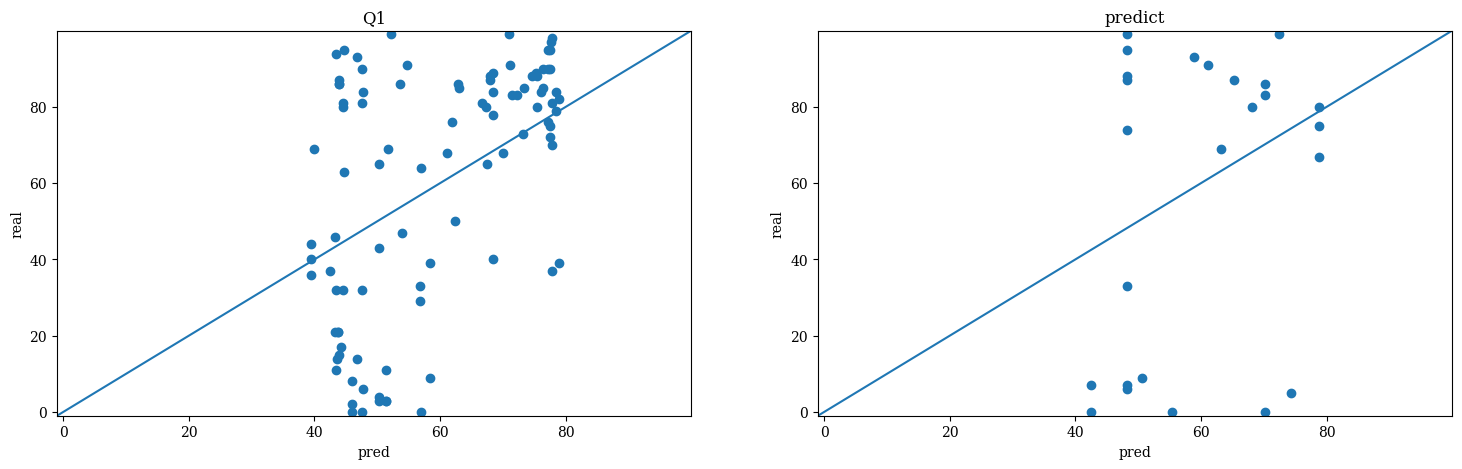

$R^{2}$=0.263
$R^{2}$=-8.185


In [31]:
best_params = study.best_params
best_model = LGBMRegressor(**best_params)
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
plt.rcParams['font.family'] = "DejaVu Serif"

# 予測値を算出)
best_model.fit(X_train_scaled, y_train)
train_y_in_cv = cross_val_predict(best_model, X_train_scaled, y_train, cv=10)
predict_y = best_model.predict(X_test_scaled)

fig = plt.figure(figsize=(18.0, 5.0))
plt.subplot(121)
plt.title('Q1')
plt.xlabel('pred')
plt.ylabel('real')
plt.scatter(train_y_in_cv, y_train)
yvalues = np.concatenate([train_y_in_cv, y_train])
ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])

plt.subplot(122)
plt.title('predict')
plt.xlabel('pred')
plt.ylabel('real')
plt.scatter(predict_y, y_test)
yvalues = np.concatenate([predict_y, y_test])
ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])

plt.show()



print('$R^{2}$=' + str(round(r2_score(y_train, train_y_in_cv), 3)))
print('$R^{2}$=' + str(round(r2_score(predict_y, y_test), 3)))

In [28]:
df3.columns

Index(['organocatalyst(mol%)', 'temp(℃)', 'time(h)', 'yield', 'R2_C', 'R2_H',
       'under_O2', 'under_air', 'solvent_CH3CN', 'solvent_DMF',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=1443)

In [35]:
df3.isna().any().value_counts()

False    1443
dtype: int64